# EPU - EPIC

EPU(Economic Policy Uncertainty) Index with KDI Economic Policy Information Database

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# for colab
"""!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!cd Mecab-ko-for-Google-Colab
!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh
"""

'!pip install konlpy\n!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git\n!cd Mecab-ko-for-Google-Colab\n!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh\n'

In [8]:
# from konlpy.tag import Mecab
# tagger = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")

# Data Load

In [54]:
raw_df = pd.read_excel("../data/epic_data.xlsx")

In [56]:
df = raw_df[['자료명', '발간일','요약']].sort_values('발간일').reset_index(drop=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237430 entries, 0 to 237429
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   자료명     237430 non-null  object
 1   발간일     237430 non-null  object
 2   요약      236493 non-null  object
dtypes: object(3)
memory usage: 5.4+ MB


# Keyword

In [58]:
# '요약' 컬럼에 지정된 단어가 포함되어 있는지 확인하는 함수
def contains_keyword(text):
    if isinstance(text, str):  # Check if the entry is a string
        return int(any(keyword in text for keyword in keywords))
    return 0  # If not a string, return 0

In [59]:
data = df.copy()

# keywords = ['불확실성', '불확실', '위기', '위험', '리스크', '불안', '우려', '걱정'] #EPU_KOR_4

keywords = ['불확실성', '불확실'] # EPU_baker

# keywords = ['불확실', '불안']

In [60]:
# 새로운 컬럼 '불확실여부' 생성
data['불확실여부'] = data['요약'].apply(contains_keyword)

# 인덱스 생성

## 날짜 전처리

In [61]:
# 날짜 형식을 datetime 형식으로 변환하는 함수
def convert_to_datetime(date_str):
    # 'yyyy.mm.' 형식인 경우
    if len(date_str) == 8 and date_str[-1] == '.':
        date_str += '01'
    # 'yyyy.mm.dd' 형식이 아니거나, 잘못된 형식인 경우 None 반환
    elif len(date_str) != 10 or not date_str.replace('.', '').isdigit():
        return None
    
    # 유효하지 않은 일자 확인 및 수정
    try:
        date = pd.to_datetime(date_str, format='%Y.%m.%d', errors='raise')
        # 유효하지 않은 월이나 일을 가진 경우 None 반환
        if date.month == 0 or date.day == 0:
            return None
    except ValueError:
        # 잘못된 날짜는 'yyyy.mm.01'로 수정
        date_str = date_str[:8] + '01'
        try:
            date = pd.to_datetime(date_str, format='%Y.%m.%d')
        except ValueError:
            return None
    return date

In [62]:
# '발간일' 컬럼을 datetime 형식으로 변환
data['발간일'] = data['발간일'].apply(convert_to_datetime)

# 필요 날짜만 고르자.
data = data[(data['발간일'] >= '1996-01-01') & (data['발간일'] <= '2024-05-31')]

## EPU Index 생성

In [63]:
def daily_epu(data):
    # 일별로 자료 총 건수와 불확실여부가 1인 자료 건수를 구함
    daily_counts = data.groupby(data['발간일'].dt.date)['불확실여부'].agg(['count', 'sum'])
    daily_counts.columns = ['total_count', 'uncertainty_count']
    
    # 불확실도 계산 (불확실여부가 1인 자료 건수 / 총 자료 건수)
    daily_counts['불확실도'] = daily_counts['uncertainty_count'] / daily_counts['total_count']
    
    # 1) 불확실도를 계산한 데이터프레임을 날짜를 인덱스로 설정
    daily_uncertainty_index = daily_counts['불확실도']
    return daily_uncertainty_index

In [64]:
def monthly_epu(data):
    # 월별로 자료 총 건수와 불확실여부가 1인 자료 건수를 구함
    monthly_counts = data.groupby(data['발간일'].dt.to_period('M'))['불확실여부'].agg(['count', 'sum'])
    monthly_counts.columns = ['total_count', 'uncertainty_count']
    
    # 불확실도 계산 (불확실여부가 1인 자료 건수 / 총 자료 건수)
    monthly_counts['불확실도'] = monthly_counts['uncertainty_count'] / monthly_counts['total_count']
    
    # 1) 불확실도를 계산한 데이터프레임을 월을 인덱스로 설정
    monthly_uncertainty_index = monthly_counts['불확실도']
    return monthly_uncertainty_index
# 2) 불확실건수로
# monthly_uncertainty_index = monthly_counts['uncertainty_count']

In [65]:
daily_uncertainty_index = daily_epu(data)
monthly_uncertainty_index = monthly_epu(data)

# Visualize

In [66]:
import matplotlib
import matplotlib.font_manager as fm

#fm.get_fo
font_location = 'C:/Windows/Fonts/Hancom Gothic Regular.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

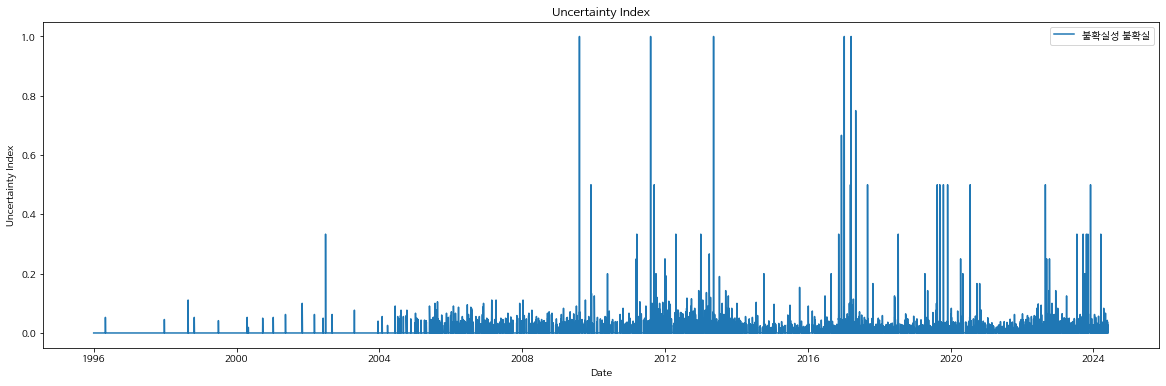

In [74]:
# 선 그래프 그리기
plt.figure(figsize=(20, 6))
daily_uncertainty_index.plot()
plt.title('Uncertainty Index')
plt.xlabel('Date')
plt.ylabel('Uncertainty Index')
plt.legend([" ".join(keywords)])
plt.show()

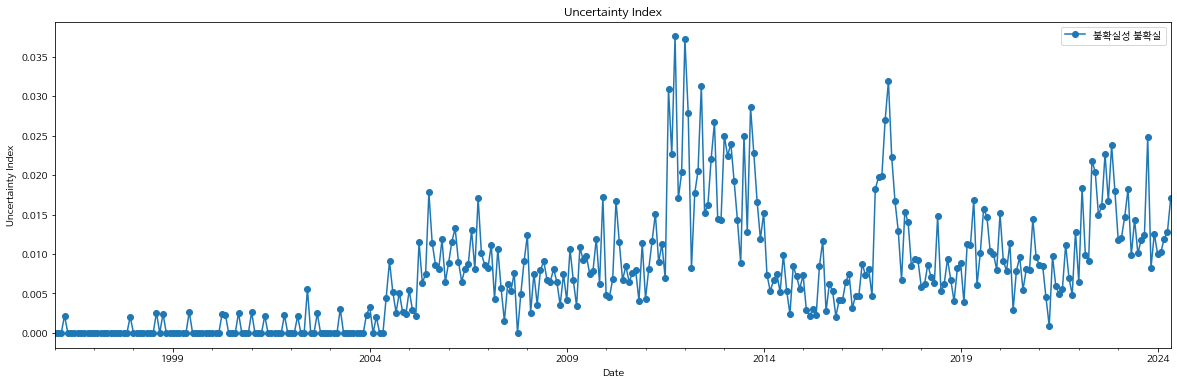

In [75]:
# 선 그래프 그리기
plt.figure(figsize=(20, 6))
monthly_uncertainty_index.plot(marker='o')
plt.title('Uncertainty Index')
plt.xlabel('Date')
plt.ylabel('Uncertainty Index')
plt.legend([" ".join(keywords)])
plt.show()